# Import Stataments

In [1]:
#Basic Import Statements
import pandas as pd
import numpy as np
import json

#Plot Import Statements
import seaborn as sns
import matplotlib.pyplot as plt

#To Ignore Warnings in Output
import warnings
warnings.filterwarnings('ignore')

#Math Import for TFIDF
from collections import Counter 
import math

## Converting Business Json file to Dataframe

###### Business file

In [2]:
#since pd.readjson will cause memeory error, we read the file line by line
path = '../data/input_json_files/yelp_academic_dataset_business.json'
business = []
with open(path, encoding = 'utf-8') as fin:
    for line in fin:
        line_contents = json.loads(line)
        business.append(line_contents)

In [3]:
#Creating business dataframe
business = pd.DataFrame(business)
business.shape

(150346, 14)

In [4]:
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


## Data Cleaning

In [5]:
#Columns in business file
business.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

### We plan to use data only for open business, so extracting subset of the business that are still operational.

In [6]:
# Recommendations will be valid only if the business is still open
# 1 = open, 0 = closed

business = business[business['is_open']==1]

#Now that we have only open businesses, the column is_open can be removed
business = business.drop(columns = ['is_open'])

In [7]:
#Checking null values
business.isnull().sum()

business_id         0
name                0
address             0
city                0
state               0
postal_code         0
latitude            0
longitude           0
stars               0
review_count        0
attributes      12348
categories         95
hours           16095
dtype: int64

###### Removing rows with null category

In [8]:
# let remove the rows for which categories are not mentioned
business = business.dropna(subset=['categories']).reset_index(drop = True)

In [9]:
business.shape

(119603, 13)

###### Retrieving food related businesses

In [10]:
#Getting count of all categories of business
business_overall = business.assign(categories = business.categories.str.split(', ')).explode('categories')
cat = business_overall.categories.value_counts()
cat = cat.to_frame().reset_index()
cat.columns = ['Categories', 'Count']
cat

,Categories,Count
0,Restaurants,34987
1,Food,20419
2,Shopping,20186
3,Home Services,13322
4,Beauty & Spas,12263
...,...,...
1297,Guamanian,1
1298,Cheese Tasting Classes,1
1299,Bike Repair,1
1300,Tonkatsu,1


In [11]:
#Category sort by count
cat= cat.sort_values(by = 'Count', ascending = False)

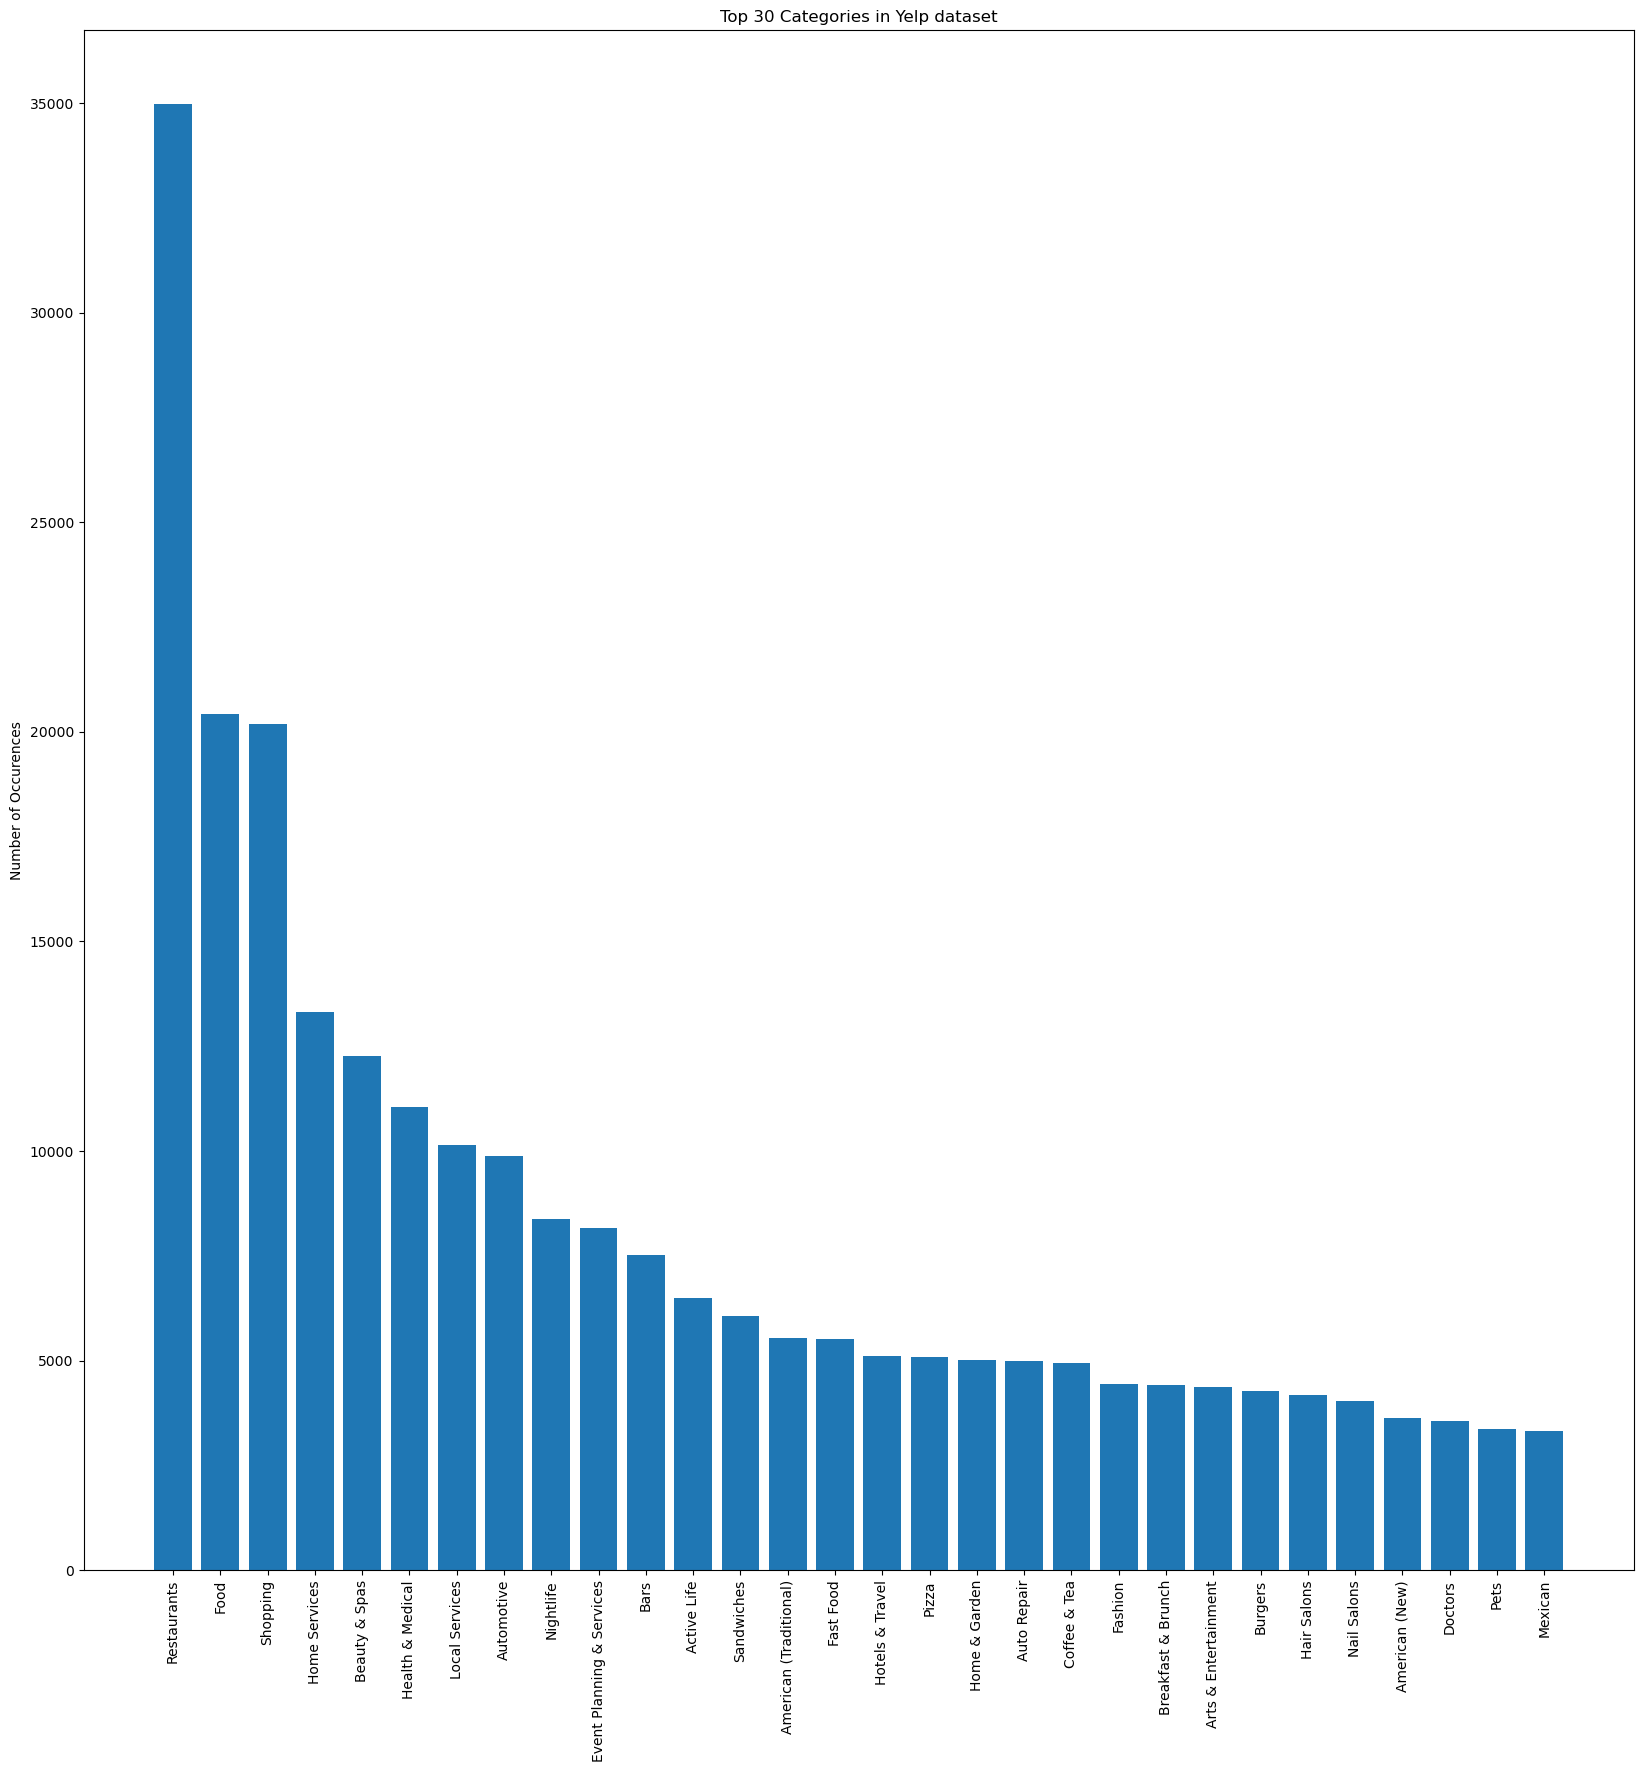

In [12]:
cat = cat[0:30]
objects = list(cat.Categories)
y_pos = np.arange(len(objects))
Numbers = list(cat.Count)

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
plt.bar(y_pos, Numbers, align='center', alpha=1)
plt.xticks(y_pos, objects,rotation=90)
plt.ylabel('Number of Occurences')
plt.title('Top 30 Categories in Yelp dataset')
plt.show()

#### Since the dataset had business in various categories, We only to plan to focus on business that are related to Restaurants, Cafe, Fast Food etc. 

#### The relavent categories extracted from the dataset are : Restaurants, Food, Sandwiches, Fast-Food, Pizza, Coffee & Tea, Breakfast&Brunch , Burgers.

In [13]:
#Creating a dataframe to retrieve only restaurant and food related businesses
b = pd.DataFrame()
food_category_filter = ['Restaurants' , 'Food' , 'Sandwiches' , 'Fast Food','Pizza' , 
                        'Coffee & Tea','Breakfast & Brunch','Burgers']

In [14]:
#Appending the data into another dataframe based on the food category filter
for index, row in business.categories.items():
    for i in range(len(food_category_filter)):
        try:
            if food_category_filter[i] in row:
                b = b.append(business.iloc[index])
                break
        except:
            print(index)
            print(food_category_filter[i])
            print(business.iloc[index])

In [15]:
#Business dataframe with food category filter
business = b.reset_index(drop = True)

In [16]:
business.to_csv('../data/output_csv/business.csv',index = False)
business = pd.read_csv('../data/output_csv/business.csv')
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,categories,hours
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
2,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."
3,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,"{'RestaurantsAttire': ""'casual'"", 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '..."
4,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,NaN,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,"{'Alcohol': ""'none'"", 'OutdoorSeating': 'None'...","Vietnamese, Food, Restaurants, Food Trucks","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'..."


In [17]:
business.shape

(44582, 13)

###### Filtering Out only one state of restaurant businesses

<AxesSubplot:xlabel='state', ylabel='count'>

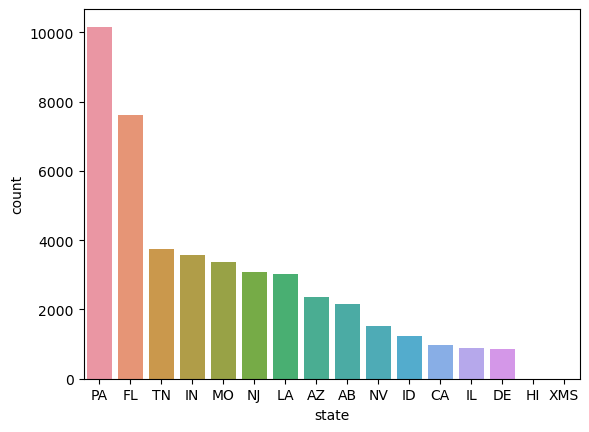

In [18]:
#Count of restaurants in each location
sns.countplot(data = business,x = 'state',
             order = business['state'].value_counts().index
             )

#### Since PA has the most number of observations, we will use only the restaurants in PA region for our Recommendation system Model

In [19]:
business = business[business['state'] == 'PA'].reset_index(drop = True)

In [20]:
business.shape

(10163, 13)

In [21]:
business.to_csv('../data/output_csv/business_PA.csv',index = False)
business = pd.read_csv('../data/output_csv/business_PA.csv')
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,categories,hours
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
2,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-..."
3,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,205,"{'NoiseLevel': ""u'quiet'"", 'GoodForMeal': ""{'d...","Korean, Restaurants","{'Monday': '11:30-20:30', 'Tuesday': '11:30-20..."
4,kV_Q1oqis8Qli8dUoGpTyQ,Ardmore Pizza,10 Rittenhouse Pl,Ardmore,PA,19003,40.006707,-75.289671,3.5,109,"{'RestaurantsGoodForGroups': 'True', 'WiFi': ""...","Pizza, Restaurants","{'Monday': '11:0-0:0', 'Tuesday': '11:0-0:0', ..."


###### Converting Attributes column into a matrix

In [22]:
#Method to convert string to json and replace special characters
def cleanup_and_convert_to_json(json_str):
    return json.loads(json_str.replace('"u', '').replace('"', '').replace("u'", "'").replace("'", '"').replace(': True', ': "True"').replace(': False', ': "False"').replace(': None', ': "None"'))


keys_list = []
json_list = []
#Iterating over all rows in business dataframe
for index,row in  business.iterrows():
    
    try:
        #String of each row value of attributes
        attributes_str = row['attributes']
        
        #Converting the string into json
        attributes_json = cleanup_and_convert_to_json(attributes_str)
        #Adding the converted clened up string to json_list
        json_list.append(attributes_json)
    except:
        #Handling null strings that cannot be converted into json and adding it into json list
        json_list.append({})
        continue
    #Getting the keys from the converted json row-value    
    for key in attributes_json.keys():
        #Appending it into key list
        keys_list.append(key)

print(json_list[0])        
#Forming a unique elements list or set of key list        
keys_set = sorted(set(keys_list))
print(keys_set)
    

{'RestaurantsDelivery': 'False', 'OutdoorSeating': 'False', 'BusinessAcceptsCreditCards': 'False', 'BusinessParking': {'garage': 'False', 'street': 'True', 'validated': 'False', 'lot': 'False', 'valet': 'False'}, 'BikeParking': 'True', 'RestaurantsPriceRange2': '1', 'RestaurantsTakeOut': 'True', 'ByAppointmentOnly': 'False', 'WiFi': 'free', 'Alcohol': 'none', 'Caters': 'True'}
['AcceptsInsurance', 'AgesAllowed', 'Alcohol', 'Ambience', 'BYOB', 'BYOBCorkage', 'BestNights', 'BikeParking', 'BusinessAcceptsBitcoin', 'BusinessAcceptsCreditCards', 'BusinessParking', 'ByAppointmentOnly', 'Caters', 'CoatCheck', 'Corkage', 'DietaryRestrictions', 'DogsAllowed', 'DriveThr', 'GoodForDancing', 'GoodForKids', 'GoodForMeal', 'HappyHour', 'HasTV', 'Music', 'NoiseLevel', 'Open24Hours', 'OutdoorSeating', 'RestaurantsAttire', 'RestaurantsCounterService', 'RestaurantsDelivery', 'RestaurantsGoodForGroups', 'RestaurantsPriceRange2', 'RestaurantsReservations', 'RestaurantsTableService', 'RestaurantsTakeOut', 

In [23]:
#Resultant dictionary
result_dict = {}
#Iterating over the length of json_array = number of rows in business
for i in range(len(json_list)):
    #Each json array element is a json_row
    json_row = json_list[i]
    #Creating a dictionary called row_dict
    row_dict = {}
    #Iterating over all the keys we have
    for j in range(len(keys_set)):
        #Current key
        key = keys_set[j]
        #If key_set's key belongs in the json row
        if key in json_row:
            #And if it is a nested json object
            if '{' in str(json_row[key]):
                #If the nested json object contains atleast one true element
                true_exists = 'True' in str(json_row[key])
                #Add True to the key or it will add false to the key
                row_dict[key] = str(true_exists)
            else:
                #Not a nested json object, takes just the value
                row_dict[key] = json_row[key]
        #If no such key_set's key belongs in the json row,
        else:
            #Just add none to the value
            row_dict[key] = 'None'
    #Resultant dictionary element
    result_dict[i] = row_dict

In [24]:
#creating an attributes dataframe
attributes_df =  pd.DataFrame(result_dict).transpose()

In [25]:
attributes_df

,AcceptsInsurance,AgesAllowed,Alcohol,Ambience,BYOB,BYOBCorkage,BestNights,BikeParking,BusinessAcceptsBitcoin,BusinessAcceptsCreditCards,...,RestaurantsCounterService,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,Smoking,WheelchairAccessible,WiFi
0,None,None,none,None,None,None,None,True,None,False,...,None,False,None,1,None,None,True,None,None,free
1,None,None,None,None,None,None,None,True,None,True,...,None,None,None,None,None,None,True,None,True,None
2,None,None,full_bar,True,None,None,None,None,None,True,...,None,True,True,2,True,True,True,None,True,free
3,None,None,none,True,None,None,None,True,None,True,...,None,None,False,1,False,True,True,None,None,no
4,None,None,none,True,None,None,None,True,None,True,...,None,True,True,1,False,None,True,None,None,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10158,None,None,None,False,None,None,None,None,None,None,...,None,False,None,2,False,None,None,None,None,None
10159,None,None,None,False,None,None,None,None,None,True,...,None,True,None,2,False,None,True,None,None,no
10160,None,None,none,True,None,None,None,True,None,True,...,None,True,False,2,False,None,True,None,None,no
10161,None,None,None,None,None,None,None,True,None,True,...,None,True,None,1,None,None,True,None,None,None


In [26]:
for i in range(len(keys_set)):
    column_name = keys_set[i]
    print(column_name)
    print("---------------")
    print(attributes_df[column_name].unique())
    print("***************")


AcceptsInsurance
---------------
['None' 'False' 'True']
***************
AgesAllowed
---------------
['None' 'allages' '21plus']
***************
Alcohol
---------------
['none' 'None' 'full_bar' 'beer_and_wine']
***************
Ambience
---------------
['None' 'True' 'False']
***************
BYOB
---------------
['None' 'False' 'True']
***************
BYOBCorkage
---------------
['None' 'yes_free' 'no' 'yes_corkage']
***************
BestNights
---------------
['None' 'False' 'True']
***************
BikeParking
---------------
['True' 'None' 'False']
***************
BusinessAcceptsBitcoin
---------------
['None' 'False' 'True']
***************
BusinessAcceptsCreditCards
---------------
['False' 'True' 'None']
***************
BusinessParking
---------------
['True' 'False' 'None']
***************
ByAppointmentOnly
---------------
['False' 'None' 'True']
***************
Caters
---------------
['True' 'False' 'None']
***************
CoatCheck
---------------
['None' 'False' 'True']
*******

In [27]:
attributes_df=attributes_df.replace('None',0).replace('none',0).replace('False',0).replace('True',1).replace('yes',1).replace('no',0).replace('0',0).replace('1',1)

In [28]:
business = pd.concat([business,attributes_df], axis=1)

In [29]:
business = business.drop(columns = ['attributes','state'])

In [30]:
for i in range(len(keys_set)):
    column_name = keys_set[i]
    print(column_name)
    print("---------------")
    print(business[column_name].unique())
    print("***************")


AcceptsInsurance
---------------
[0 1]
***************
AgesAllowed
---------------
[0 'allages' '21plus']
***************
Alcohol
---------------
[0 'full_bar' 'beer_and_wine']
***************
Ambience
---------------
[0 1]
***************
BYOB
---------------
[0 1]
***************
BYOBCorkage
---------------
[0 'yes_free' 'yes_corkage']
***************
BestNights
---------------
[0 1]
***************
BikeParking
---------------
[1 0]
***************
BusinessAcceptsBitcoin
---------------
[0 1]
***************
BusinessAcceptsCreditCards
---------------
[0 1]
***************
BusinessParking
---------------
[1 0]
***************
ByAppointmentOnly
---------------
[0 1]
***************
Caters
---------------
[1 0]
***************
CoatCheck
---------------
[0 1]
***************
Corkage
---------------
[0 1]
***************
DietaryRestrictions
---------------
[0 1]
***************
DogsAllowed
---------------
[0 1]
***************
DriveThr
---------------
[0 1]
***************
GoodForDancing


In [31]:
business['RestaurantsPriceRange2'] = business['RestaurantsPriceRange2'].replace('2',2).replace('3',3).replace('4',4)
business['Alcohol'] = business['Alcohol'].replace('full_bar',1).replace('beer_and_wine',1)
business['Smoking'] = business['Smoking'].replace('outdoor',1)
business.head()

,business_id,name,address,city,postal_code,latitude,longitude,stars,review_count,categories,...,RestaurantsCounterService,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,Smoking,WheelchairAccessible,WiFi
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,19107,39.955505,-75.155564,4.0,80,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",...,0,0,0,1,0,0,1,0,0,free
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,18054,40.338183,-75.471659,4.5,13,"Brewpubs, Breweries, Food",...,0,0,0,0,0,0,1,0,1,0
2,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,19106,39.953949,-75.143226,4.0,245,"Sushi Bars, Restaurants, Japanese",...,0,1,1,2,1,1,1,0,1,free
3,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,19147,39.943223,-75.162568,4.5,205,"Korean, Restaurants",...,0,0,0,1,0,1,1,0,0,0
4,kV_Q1oqis8Qli8dUoGpTyQ,Ardmore Pizza,10 Rittenhouse Pl,Ardmore,19003,40.006707,-75.289671,3.5,109,"Pizza, Restaurants",...,0,1,1,1,0,0,1,0,0,0


In [32]:
business.shape

(10163, 49)

###### Dealing with Restaurant categories 

In [33]:
#get frequencies of categories in the dataset
category_name = []
num_tags = []

for i in range(business.shape[0]):
    category_list = business['categories'][i].split(", ")
    
    for category in category_list:
        category_name.append(category)
        num_tags.append(len(category))

In [34]:
# Calling DataFrame constructor after zipping
# both lists, with columns specified
category_frequency = pd.DataFrame(list(zip(category_name, num_tags)),columns =['Category_Name', 'Frequency'])

In [35]:
#Get the count of most common category frequency words
new_feature = Counter(category_frequency['Category_Name']).most_common(100)

feature = pd.DataFrame()
for ind,val in enumerate(new_feature[2:]):
    
    feature.loc[ind,'Feature'] = val[0]
    #idf(t) = N/df
    feature.loc[ind,'IDF'] =  math.log1p(len(business.business_id) / val[1])

In [36]:
feature.head()

,Feature,IDF
0,Pizza,2.049216
1,Sandwiches,2.066210
2,Nightlife,2.153242
3,Bars,2.191907
4,Coffee & Tea,2.230348


In [37]:
#Adding the category as features into the dataframe
data_business2 = business

for ind in range(feature.shape[0]):
    ft = feature.loc[ind,'Feature']
    for i in range(data_business2.shape[0]):
        each_line = data_business2['categories'][i].split(", ")
        if ft in each_line:
            data_business2.loc[i,ft] = 1 
        else:
            data_business2.loc[i,ft] = 0


In [38]:
business = data_business2
business.head()

,business_id,name,address,city,postal_code,latitude,longitude,stars,review_count,categories,...,Seafood Markets,Wraps,Shaved Ice,Cupcakes,Greek,Flowers & Gifts,Home & Garden,French,Candy Stores,Chocolatiers & Shops
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,19107,39.955505,-75.155564,4.0,80,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,18054,40.338183,-75.471659,4.5,13,"Brewpubs, Breweries, Food",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,19106,39.953949,-75.143226,4.0,245,"Sushi Bars, Restaurants, Japanese",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,19147,39.943223,-75.162568,4.5,205,"Korean, Restaurants",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,kV_Q1oqis8Qli8dUoGpTyQ,Ardmore Pizza,10 Rittenhouse Pl,Ardmore,19003,40.006707,-75.289671,3.5,109,"Pizza, Restaurants",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
business.isnull().sum()

business_id              0
name                     0
address                 75
city                     0
postal_code              0
                        ..
Flowers & Gifts          0
Home & Garden            0
French                   0
Candy Stores             0
Chocolatiers & Shops     0
Length: 147, dtype: int64

In [40]:
business.to_csv('../data/output_csv/business_PA_clean.csv',index = False)
business = pd.read_csv('../data/output_csv/business_PA_clean.csv')
business.head()

,business_id,name,address,city,postal_code,latitude,longitude,stars,review_count,categories,...,Seafood Markets,Wraps,Shaved Ice,Cupcakes,Greek,Flowers & Gifts,Home & Garden,French,Candy Stores,Chocolatiers & Shops
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,19107,39.955505,-75.155564,4.0,80,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,18054,40.338183,-75.471659,4.5,13,"Brewpubs, Breweries, Food",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,19106,39.953949,-75.143226,4.0,245,"Sushi Bars, Restaurants, Japanese",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,19147,39.943223,-75.162568,4.5,205,"Korean, Restaurants",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,kV_Q1oqis8Qli8dUoGpTyQ,Ardmore Pizza,10 Rittenhouse Pl,Ardmore,19003,40.006707,-75.289671,3.5,109,"Pizza, Restaurants",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='city', ylabel='count'>

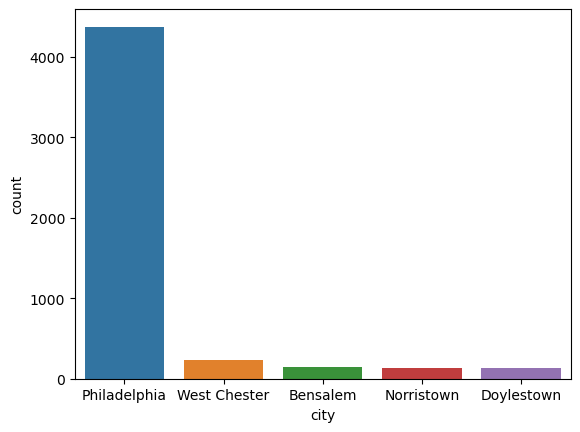

In [41]:
#Count of restaurants in each location
sns.countplot(data = business,x = 'city',
             order = business['city'].value_counts().iloc[:5].index
             )

In [42]:
business = business[business['city'] == 'Philadelphia'].reset_index(drop = True)

In [43]:
business.to_csv('../data/output_csv/business_PA_Philly_clean.csv',index = False)